### Dan Sokolsky
### ds3837@nyu.edu
### March 2, 2021
### Homework #2


### We explore The Markov Chain Monte Carlo (MCMC)
### Metropolis-Hastings algorithm and how a variety of variables
### affect the sampling scheme.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal


histogram_bins = np.arange(0, 5, 0.25)
number_of_trials = 100000


def get_invariant_mean(dimensions):
    return np.zeros(dimensions)


def get_invariant_sigma():
    return 1.5


def get_uniform_sample():
    return np.random.uniform(0, 1)


def prepare_mcmc_samples(dimensions, proposal_sigma):
    invariant_mean = get_invariant_mean(dimensions)
    invariant_sigma = get_invariant_sigma()
    invariant_mvn = get_mvn(dimensions, invariant_mean, invariant_sigma)
    proposal_variance = proposal_sigma ** 2
    proposal_cov = proposal_variance * np.array(np.identity(dimensions))

    # set initial proposal - all coordinates = 1
    current_proposal = np.ones(dimensions)

    samples = [current_proposal]
    for _ in range(number_of_trials):
        proposal = np.random.multivariate_normal(current_proposal, proposal_cov)
        u = get_uniform_sample()
        alpha = invariant_mvn.pdf(proposal) / invariant_mvn.pdf(current_proposal)
        if u < alpha:
            samples.append(proposal)
            current_proposal = proposal
    return samples


def prepare_mcmc_samples_one_dim_at_a_time(dimensions, proposal_sigma):
    invariant_mean = get_invariant_mean(dimensions)
    invariant_sigma = get_invariant_sigma()
    invariant_mvn = get_mvn(dimensions, invariant_mean, invariant_sigma)
    proposal_variance = proposal_sigma ** 2
    proposal_cov = proposal_variance * np.array(np.identity(dimensions))

    # set initial proposal - all coordinates = 1
    current_proposal = np.ones(dimensions)

    samples = [current_proposal]
    for _ in range(int(np.round(number_of_trials / dimensions))):
        for dim in range(dimensions):
            proposal = np.copy(current_proposal)
            proposal[dim] = np.random.normal(proposal[dim], proposal_sigma) 
            u = get_uniform_sample()
            alpha = invariant_mvn.pdf(proposal) / invariant_mvn.pdf(current_proposal)
            if u < alpha:
                samples.append(proposal)
                current_proposal = proposal
    return samples


def plot_histograms_by_distance(dimensions, samples):
    # plot normalized histogram of amount of successful samples by distance from the invariant mean
    invariant_mean = get_invariant_mean(dimensions)
    distances = [np.linalg.norm(x - invariant_mean) for x in samples]
    plt.hist(distances, bins=histogram_bins, density=True, label='MCMC Sampling')

    # invariant normal distribution by distance
    plot_normal_distribution_by_distance(dimensions, get_invariant_mean(dimensions), get_invariant_sigma())
    plt.xlabel('Distance from mean')
    plt.ylabel('Probability')
    plt.title(f'Probability by distance from mean\nNumber of dimensions: {dimensions}')
    plt.legend()
    plt.show()


def get_mvn(dimensions, mean, sigma):
    cov = (sigma ** 2) * np.array(np.identity(dimensions))
    mvn = multivariate_normal(mean, cov)
    return mvn


def plot_normal_distribution_by_distance(dimensions, mean, sigma):
    cov = (sigma ** 2) * np.array(np.identity(dimensions))
    distances = []
    signed_distances = []
    for _ in range(100000):
        x = np.random.multivariate_normal(mean, cov)
        distance = np.linalg.norm(x - mean)
#         signed_distance = np.sign(np.linalg.det([x, mean])) * distance
        distances.append(distance)
#         signed_distances.append(signed_distance)
        
    plt.hist(distances, bins=histogram_bins, density=True, histtype='step', label='Normal distribution')


### In our experiment the invariant distribution is symmetrical.
### Therefore we can measure the fraction of results by distance from the mean.
### It should be similar to the probablility by distance of our
### invariant normal distribution.
### We will do it for dimensions 1 to 5

In [ ]:
for dimensions in range(1,6):
    samples = prepare_mcmc_samples(dimensions, 2)
    plot_histograms_by_distance(dimensions, samples)


### Now let's see how the number of accepted samples depends on dimension.

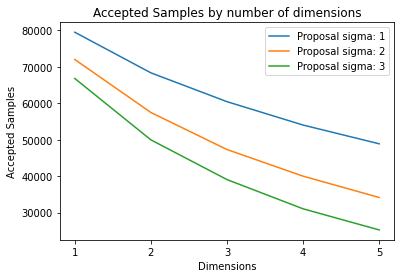

In [5]:
sigmas = [1,2,3]
for sigma in sigmas:
    x_vals = []
    y_vals = []
    for dimensions in range(1,6):
        samples = prepare_mcmc_samples(dimensions, sigma)
        x_vals.append(dimensions)
        y_vals.append(len(samples))
    plt.plot(x_vals, y_vals, label=f'Proposal sigma: {sigma}')   
plt.xticks(np.arange(1,6))    
plt.xlabel('Dimensions')
plt.ylabel('Accepted Samples')    
plt.title('Accepted Samples by number of dimensions')
plt.legend()
plt.show()

### We see that the number of accepted samples decreases as the dimension increases. I.e., it is
### more difficult to sample a higher dimensional distribution, as expected (the curse of dimensionality).

### Now let's see how the number of accepted samples depends on sigma of the propsal distribution.

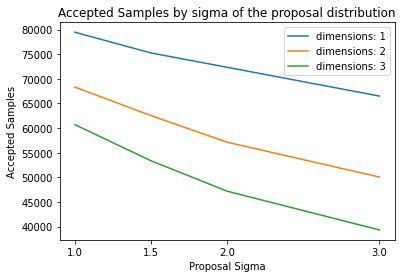

In [7]:
sigmas = [1,1.5,2,3]
for dimensions in range(1,4):
    x_vals = []
    y_vals = []
    for sigma in sigmas:
        samples = prepare_mcmc_samples(dimensions, sigma)
        x_vals.append(sigma)
        y_vals.append(len(samples))
    plt.plot(x_vals, y_vals, label=f'dimensions: {dimensions}')   
plt.xticks(sigmas)    
plt.xlabel('Proposal Sigma')
plt.ylabel('Accepted Samples')    
plt.title('Accepted Samples by sigma of the proposal distribution')
plt.legend()
plt.show()

### We see a similar effect with the standard deviation. As the standard deviation of the proposal dstribution
### grows larger, we see that we start accepting less samples.

### Now lets try another proposal selection strategy: change one dimension at a time.
### As shown in a plot below, this strategy works substantially better for dimensions >= 2

In [ ]:
bar_width = 0.25
for dimensions in range(1,6):
    samples = prepare_mcmc_samples(dimensions, 2)
    plt.bar(dimensions, len(samples), width=bar_width, color='blue')
    samples1 = prepare_mcmc_samples_one_dim_at_a_time(dimensions, 2)
    plt.bar(dimensions + bar_width, len(samples1), width=bar_width, color='red')

plt.xticks(np.arange(1,6))    
plt.xlabel('Dimensions')
plt.ylabel('Accepted Samples')    
plt.title('Accepted Samples by proposal strategy\n' + 
          'Blue bars - Regular Proposal Strategy\n' +
          'Red bars - One dimension at a time')
# plt.legend(labels=('Regular proposal selection','One dimension at a time'))
plt.show()


### Also using "One dimension at a time" strategy we get better fit for the invariant distribution

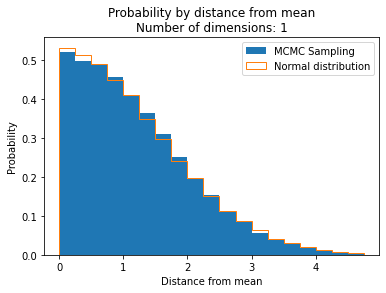

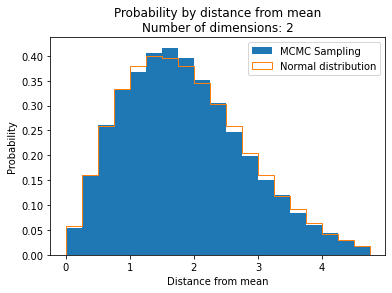

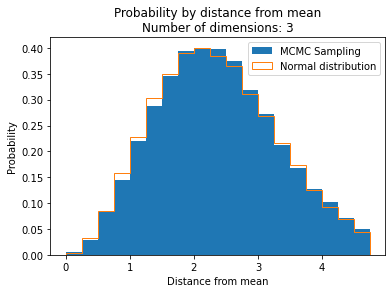

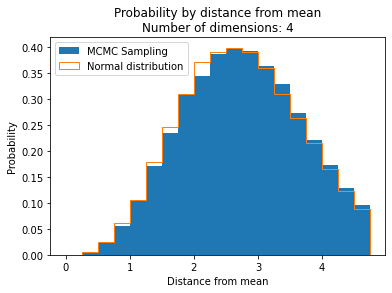

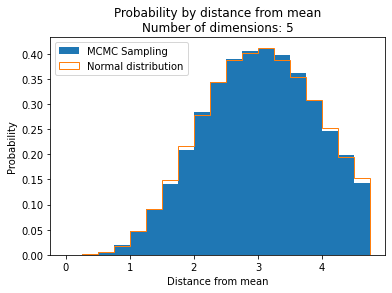

In [12]:
for dimensions in range(1,6):
    samples = prepare_mcmc_samples_one_dim_at_a_time(dimensions, 2)
    plot_histograms_by_distance(dimensions, samples)

### We see that this strategy signifcantly improves sampling.